In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [3]:
df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df.shape

(6435, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [7]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [9]:
df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Weeek_Of_Year'] = df['Date'].dt.isocalendar().week

In [12]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Weeek_Of_Year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9


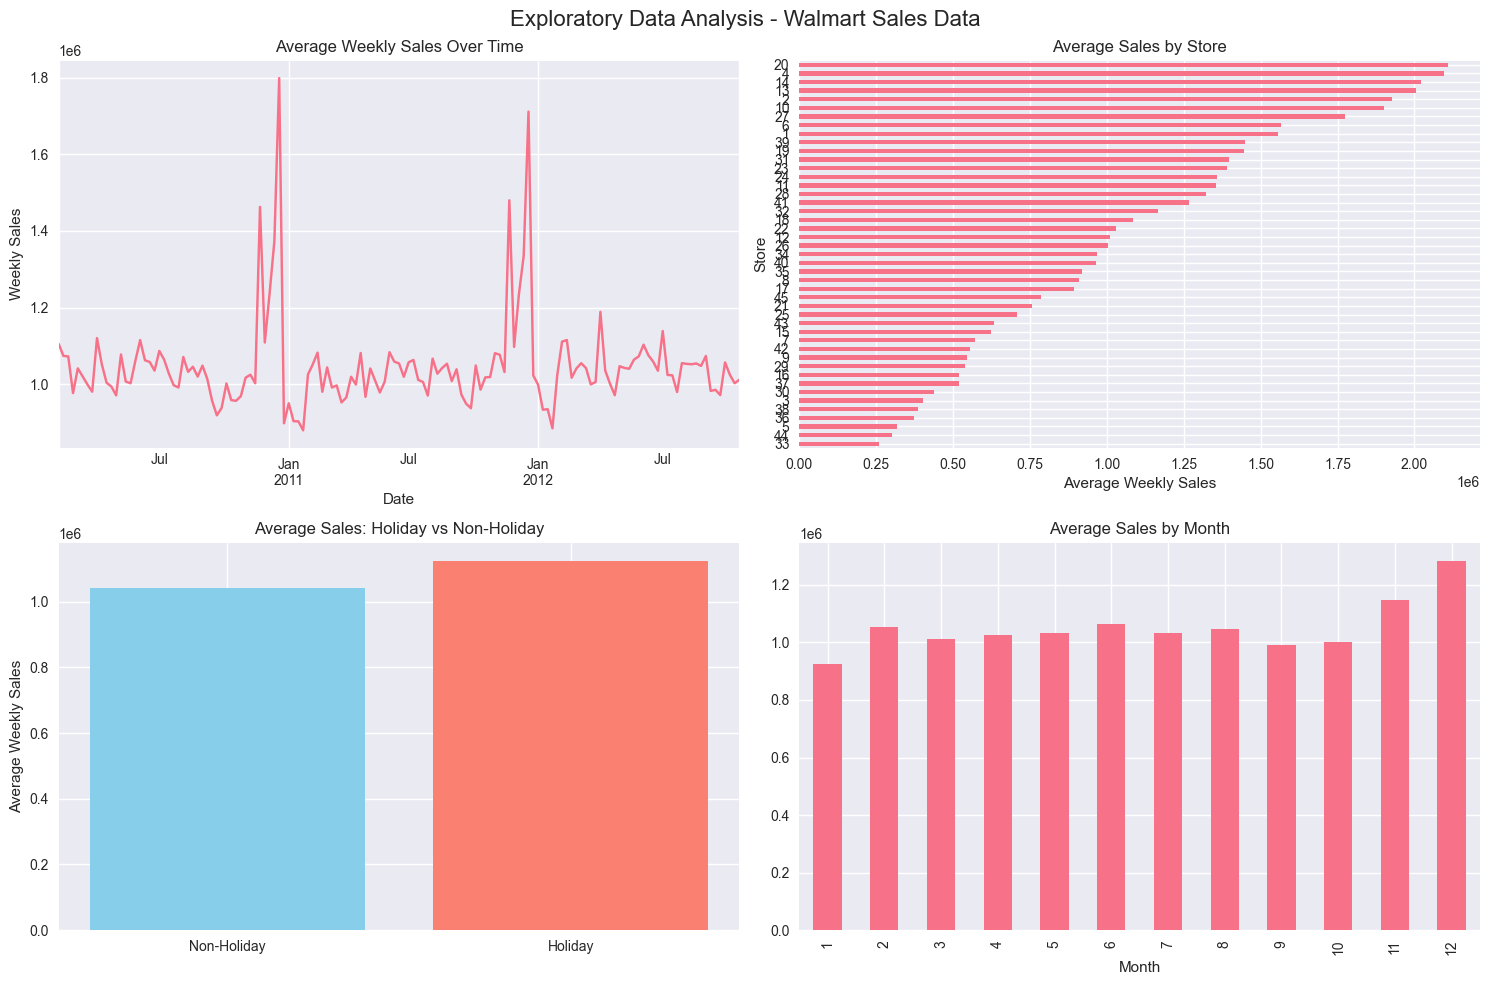

In [13]:
# Set up the visualization framework
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis - Walmart Sales Data', fontsize=16)

# Plot 1: Sales trend over time
df.groupby('Date')['Weekly_Sales'].mean().plot(ax=axes[0,0], title='Average Weekly Sales Over Time')
axes[0,0].set_ylabel('Weekly Sales')

# Plot 2: Sales by store
df.groupby('Store')['Weekly_Sales'].mean().sort_values().plot(kind='barh', ax=axes[0,1], title='Average Sales by Store')
axes[0,1].set_xlabel('Average Weekly Sales')

# Plot 3: Holiday vs Non-Holiday sales
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
axes[1,0].bar(['Non-Holiday', 'Holiday'], holiday_sales.values, color=['skyblue', 'salmon'])
axes[1,0].set_title('Average Sales: Holiday vs Non-Holiday')
axes[1,0].set_ylabel('Average Weekly Sales')

# Plot 4: Monthly sales pattern
df.groupby('Month')['Weekly_Sales'].mean().plot(ax=axes[1,1], kind='bar', title='Average Sales by Month')
axes[1,1].set_xlabel('Month')

plt.tight_layout()
plt.show()

Correlation with Weekly_Sales:
Weekly_Sales     1.000000
Month            0.076143
Weeek_Of_Year    0.074211
Holiday_Flag     0.036891
Fuel_Price       0.009464
Date             0.006949
Year            -0.018378
Temperature     -0.063810
CPI             -0.072634
Unemployment    -0.106176
Store           -0.335332
Name: Weekly_Sales, dtype: float64


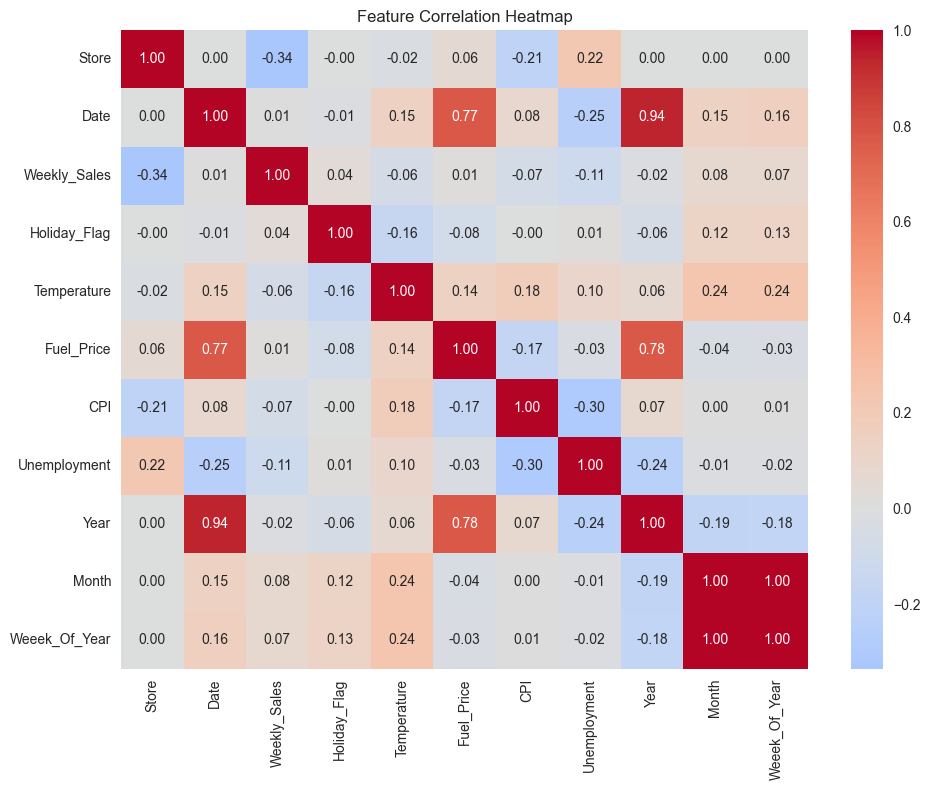

In [14]:
# Calculate correlation with Weekly_Sales
correlation_with_target = df.corr()['Weekly_Sales'].sort_values(ascending=False)
print("Correlation with Weekly_Sales:")
print(correlation_with_target)

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [15]:
# Create advanced time-based features
df['Day_Of_Year'] = df['Date'].dt.dayofyear
df['Quarter'] = df['Date'].dt.quarter

# Create holiday-related features
# Mark weeks before and after major holidays
df['Is_Week_Before_Holiday'] = df['Holiday_Flag'].shift(-1, fill_value=0)
df['Is_Week_After_Holiday'] = df['Holiday_Flag'].shift(1, fill_value=0)

# Create lag features (sales from previous periods)
df['Sales_Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['Sales_Lag_4'] = df.groupby('Store')['Weekly_Sales'].shift(4)  # same period last month
df['Sales_Lag_52'] = df.groupby('Store')['Weekly_Sales'].shift(52)  # same period last year

# Create rolling statistics
df['Rolling_Mean_4'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(4, 1).mean())
df['Rolling_Std_4'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(4, 1).std())

# Display the new features
print("Dataset with new engineered features:")
print(f"Shape: {df.shape}")
display(df[['Store', 'Date', 'Weekly_Sales', 'Sales_Lag_1', 'Sales_Lag_52', 'Rolling_Mean_4']].head(10))

Dataset with new engineered features:
Shape: (6435, 20)


,Store,Date,Weekly_Sales,Sales_Lag_1,Sales_Lag_52,Rolling_Mean_4
0,1,2010-02-05,1643690.90,NaN,NaN,1.643691e+06
1,1,2010-02-12,1641957.44,1643690.90,NaN,1.642824e+06
2,1,2010-02-19,1611968.17,1641957.44,NaN,1.632539e+06
3,1,2010-02-26,1409727.59,1611968.17,NaN,1.576836e+06
4,1,2010-03-05,1554806.68,1409727.59,NaN,1.554615e+06
5,1,2010-03-12,1439541.59,1554806.68,NaN,1.504011e+06
6,1,2010-03-19,1472515.79,1439541.59,NaN,1.469148e+06
7,1,2010-03-26,1404429.92,1472515.79,NaN,1.467823e+06
8,1,2010-04-02,1594968.28,1404429.92,NaN,1.477864e+06
9,1,2010-04-09,1545418.53,1594968.28,NaN,1.504333e+06


In [16]:
# Handle missing values created by lag features
df_clean = df.dropna().copy()

# Define features and target
feature_columns = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                  'Year', 'Month', 'Weeek_Of_Year', 'Day_Of_Year', 'Quarter',
                  'Is_Week_Before_Holiday', 'Is_Week_After_Holiday',
                  'Sales_Lag_1', 'Sales_Lag_4', 'Sales_Lag_52', 
                  'Rolling_Mean_4', 'Rolling_Std_4']

X = df_clean[feature_columns]
y = df_clean['Weekly_Sales']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# For time series, we should split by date, not randomly
split_date = '2012-06-01'  # Use first part for training, last for testing
train_mask = df_clean['Date'] < split_date
test_mask = df_clean['Date'] >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training date range: {df_clean[train_mask]['Date'].min()} to {df_clean[train_mask]['Date'].max()}")
print(f"Test date range: {df_clean[test_mask]['Date'].min()} to {df_clean[test_mask]['Date'].max()}")

Features shape: (4095, 18)
Target shape: (4095,)
Training set size: 3105
Test set size: 990
Training date range: 2011-02-04 00:00:00 to 2012-05-25 00:00:00
Test date range: 2012-06-01 00:00:00 to 2012-10-26 00:00:00


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Store                   6435 non-null   int64         
 1   Date                    6435 non-null   datetime64[ns]
 2   Weekly_Sales            6435 non-null   float64       
 3   Holiday_Flag            6435 non-null   int64         
 4   Temperature             6435 non-null   float64       
 5   Fuel_Price              6435 non-null   float64       
 6   CPI                     6435 non-null   float64       
 7   Unemployment            6435 non-null   float64       
 8   Year                    6435 non-null   int32         
 9   Month                   6435 non-null   int32         
 10  Weeek_Of_Year           6435 non-null   UInt32        
 11  Day_Of_Year             6435 non-null   int32         
 12  Quarter                 6435 non-null   int32   

In [18]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

    print(f"{name} Results:")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 50)

Training Linear Regression...
Linear Regression Results:
  MAE: $48,774.49
  RMSE: $67,155.22
  R² Score: 0.9842
--------------------------------------------------
Training Random Forest...
Random Forest Results:
  MAE: $34,068.48
  RMSE: $54,273.95
  R² Score: 0.9897
--------------------------------------------------
Training XGBoost...
XGBoost Results:
  MAE: $40,753.21
  RMSE: $64,279.06
  R² Score: 0.9855
--------------------------------------------------


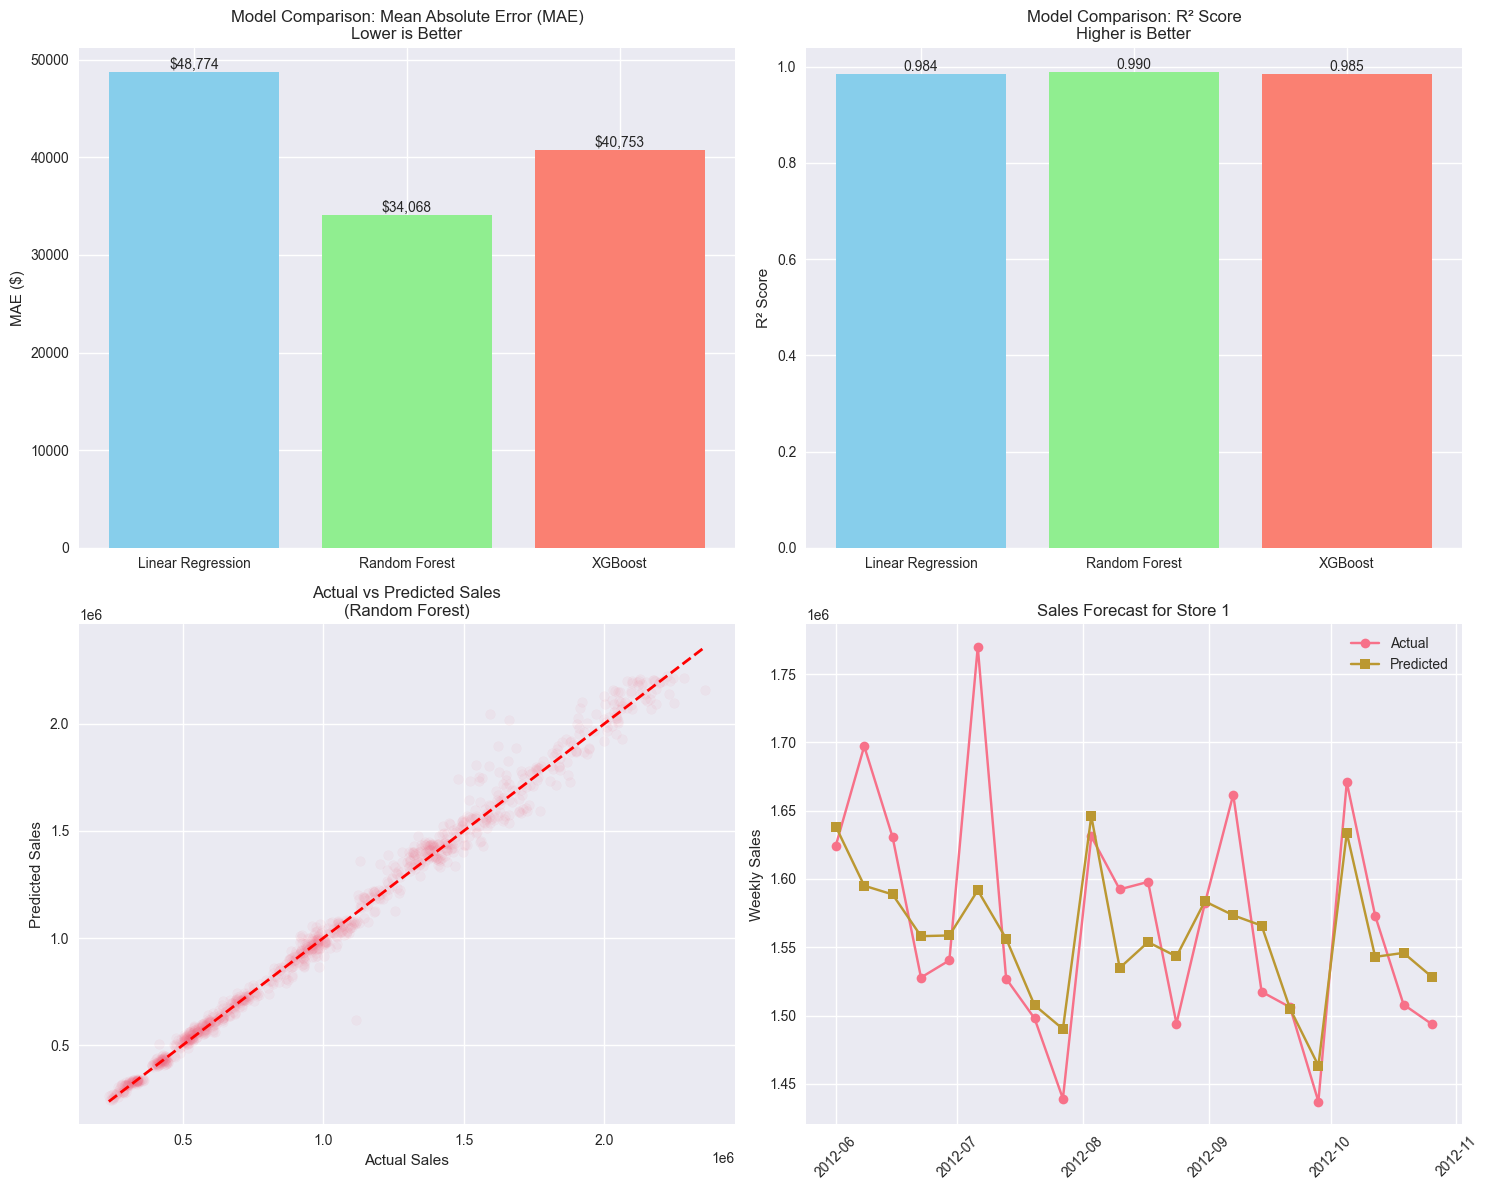


Best performing model: Random Forest


In [20]:
# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Model performance comparison
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['mae'] for model in results],
    'RMSE': [results[model]['rmse'] for model in results],
    'R²': [results[model]['r2'] for model in results]
})

# MAE Comparison
axes[0,0].bar(metrics_df['Model'], metrics_df['MAE'], color=['skyblue', 'lightgreen', 'salmon'])
axes[0,0].set_title('Model Comparison: Mean Absolute Error (MAE)\nLower is Better')
axes[0,0].set_ylabel('MAE ($)')
for i, v in enumerate(metrics_df['MAE']):
    axes[0,0].text(i, v, f'${v:,.0f}', ha='center', va='bottom')

# R² Comparison
axes[0,1].bar(metrics_df['Model'], metrics_df['R²'], color=['skyblue', 'lightgreen', 'salmon'])
axes[0,1].set_title('Model Comparison: R² Score\nHigher is Better')
axes[0,1].set_ylabel('R² Score')
for i, v in enumerate(metrics_df['R²']):
    axes[0,1].text(i, v, f'{v:.3f}', ha='center', va='bottom')

# Plot 2: Actual vs Predicted for the best model
best_model_name = min(results, key=lambda x: results[x]['mae'])
best_predictions = results[best_model_name]['predictions']

axes[1,0].scatter(y_test, best_predictions, alpha=0.06)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Sales')
axes[1,0].set_ylabel('Predicted Sales')
axes[1,0].set_title(f'Actual vs Predicted Sales\n({best_model_name})')

# Plot 3: Time series of actual vs predicted for a sample store
sample_store = X_test['Store'].iloc[0]
store_mask = X_test['Store'] == sample_store
sample_dates = df_clean[test_mask]['Date'][store_mask]
sample_actual = y_test[store_mask]
sample_pred = best_predictions[store_mask]

axes[1,1].plot(sample_dates, sample_actual, label='Actual', marker='o')
axes[1,1].plot(sample_dates, sample_pred, label='Predicted', marker='s')
axes[1,1].set_title(f'Sales Forecast for Store {sample_store}')
axes[1,1].set_ylabel('Weekly Sales')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nBest performing model: {best_model_name}")

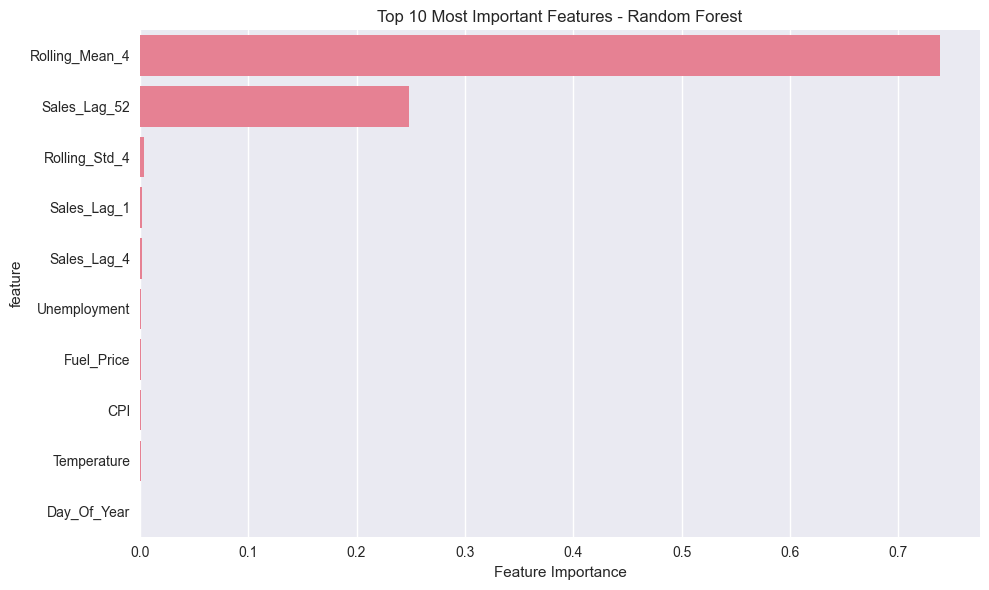

Top 10 Most Important Features:


,feature,importance
16,Rolling_Mean_4,0.738628
15,Sales_Lag_52,0.248468
17,Rolling_Std_4,0.003495
13,Sales_Lag_1,0.001757
14,Sales_Lag_4,0.001704
5,Unemployment,0.001198
3,Fuel_Price,0.000982
4,CPI,0.000899
2,Temperature,0.000876
9,Day_Of_Year,0.000509


In [22]:
# Get feature importance from the best tree-based model
if best_model_name != 'Linear Regression':
    best_model = results[best_model_name]['model']
    
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
        plt.title(f'Top 10 Most Important Features - {best_model_name}')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        display(feature_importance.head(10))

In [25]:
# Select the best model
final_model_name = best_model_name
final_model = results[final_model_name]['model']
final_predictions = results[final_model_name]['predictions']

print("=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)
print(f"Selected Model: {final_model_name}")
print(f"Mean Absolute Error: ${results[final_model_name]['mae']:,.2f}")
print(f"Root Mean Squared Error: ${results[final_model_name]['rmse']:,.2f}")
print(f"R² Score: {results[final_model_name]['r2']:.4f}")

# Business interpretation
avg_weekly_sales = y_test.mean()
mae_percentage = (results[final_model_name]['mae'] / avg_weekly_sales) * 100

print(f"\nBUSINESS INTERPRETATION:")
print(f"On average, our predictions are within ${results[final_model_name]['mae']:,.0f} of actual sales")
print(f"This represents an error of {mae_percentage:.1f}% of average weekly sales")
print(f"The model explains {results[final_model_name]['r2']*100:.1f}% of the variance in weekly sales")

# Save the final model
import joblib
joblib.dump(final_model, 'walmart_sales_predictor.pkl')
print(f"\nModel saved as 'walmart_sales_predictor.pkl'")

FINAL MODEL SUMMARY
Selected Model: Random Forest
Mean Absolute Error: $34,068.48
Root Mean Squared Error: $54,273.95
R² Score: 0.9897

BUSINESS INTERPRETATION:
On average, our predictions are within $34,068 of actual sales
This represents an error of 3.3% of average weekly sales
The model explains 99.0% of the variance in weekly sales

Model saved as 'walmart_sales_predictor.pkl'


In [1]:
import joblib
import os

print("Checking the .pkl file...")
try:
    model = joblib.load('walmart_sales_predictor.pkl')
    print("✅ File loaded successfully!")
    print(f"Loaded object type: {type(model)}")
except Exception as e:
    print(f"❌ Error loading file: {e}")

Checking the .pkl file...
✅ File loaded successfully!
Loaded object type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
